# Yeast Data Set 
## Description

Data set of yeast samples containing their attributes as well as the localization of their proteins within the sample.

The column attributes are as follows:

| Id | Attribute |Domain |
| -   | ----------- |----------- |
| 1   | Sequence Name | Number and letter sequence. |
| 2   |  McGeoch's method for signal sequence recognition.   | 0 - 1 |
| 3   | Von Heijne's method for signal sequence recognition. |0 - 1 |
| 4   | Score of the ALOM membrane spanning region prediction program. | 0 - 1 |
| 5   | Score of discriminant analysis of the amino acid content of the N-terminal region. | 0 - 1 |
| 6   | Presence of "HDEL" substring (thought to act as a signal forretention in the endoplasmic reticulum lumen).Binary attribute. | 0 or 0.5 |
| 7   | Peroxisomal targeting signal in the C-terminus.   |0 - 1 |
| 8   |  Score of discriminant analysis of the amino acid content of vacuolar and extracellular proteins.| 0 - 1 |
| 9   | Score of discriminant analysis of nuclear localization signals of nuclear and non-nuclear proteins.| 0 - 1 |
| 10  | The class of the yeast sample. | Location ID |

## Importing and processing dataset

In [1]:
import os                        # for os.path.exists
import json                      # for loading metadata
import urllib                    # for downloading remote files 
import numpy as np
import pandas as pd

In [2]:
def download(remoteurl: str, localfile: str):
    """
    Download remoteurl to localfile, unless localfile already exists.
    Returns the localfile string.
    """
    localfile = "../../datasets/classification/"+localfile
    if not os.path.exists(localfile):
        print("Downloading %s..." % localfile)
        filename, headers = urllib.request.urlretrieve(remoteurl, localfile)
    return localfile

In [3]:
yeast_data = download("https://archive.ics.uci.edu/ml/machine-learning-databases/yeast/yeast.data","yeast-data")
headers = ['Sequence_name','MCG','GVH','ALM','MIT', 'ERL','POX','VAC','NUC', 'Class']
data = pd.read_csv(yeast_data, header = None, names = headers, delimiter=r"\s+")
data.head()

X = (data.iloc[:,1:data.shape[1]-1]).to_numpy().flatten().reshape(data.shape[0],-1)
y = data.iloc[:,data.shape[1]-1:data.shape[1]]

y.Class = pd.Categorical(y.Class)
y.Class = y.Class.cat.codes
y = y.to_numpy().flatten()


## Importing libraries

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import sklearn.tree
import sklearn.neighbors
import sklearn.ensemble
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

## Define training and plotting methods

In [5]:
def train_estimators(X, y, estimator_type, param_name, param_vals, **kwargs):
    """
    
    Trains multiple instances of `estimator_type` on (X, y) by setting argument
    named `param_name` to each value in `param_vals`. Prints a message before
    training each instance. Returns the list of trained estimators.
    
    For example:
    
       >>> train_estimators(X, y, DecisionTreeClassifier, 'max_depth', [1, 5, 10],
                            splitter='random', random_state=0)
    
       Training DecisionTreeClassifier(max_depth=1, random_state=0, splitter='random')...
       Training DecisionTreeClassifier(max_depth=5, random_state=0, splitter='random')...
       Training DecisionTreeClassifier(max_depth=10, random_state=0, splitter='random')...

       [DecisionTreeClassifier(max_depth=1, random_state=0, splitter='random'),
        DecisionTreeClassifier(max_depth=5, random_state=0, splitter='random'),
        DecisionTreeClassifier(max_depth=10, random_state=0, splitter='random')] 
    """
    # Your implementation here. Aim for 5-10 lines.
    estimators = []
    extra_params = ''

    for arg in kwargs:
        extra_params = extra_params + str(arg) + '=' + str(kwargs[arg])+ ', ' 
        
    for val in param_vals:
        estimator = estimator_type(**{param_name : val}, **kwargs).fit(X,y)
        estimators.append(estimator)
        print('Training' + ' ' +str(estimator.__class__.__name__) +'(' + str(param_name) + '=' + str(val) + ', ' + extra_params + ')...')

    return estimators;

In [6]:
def plot_estimator_scores(estimators, param_name, param_vals):
    """
    Plots the training, validation, and testing scores of a list of estimators,
    where `param_name` and `param_vals` are the same as for `train_estimators`.
    The estimator with best validation score will be highlighted with an 'x'.
    """
    # Your implementation here. Use as many lines as you need.

    N = len(param_vals)
    x2 = np.arange(N)
    
    training_scores = score_estimators(X_train, y_train, estimators)
    test_scores = score_estimators(X_test, y_test, estimators)
    val_scores = score_estimators(X_val, y_val, estimators)
    
    val_score_index = val_scores.index(np.max(val_scores))
    
    plt.plot(x2, training_scores, '-ok', color = 'g', label = 'train')
    plt.plot(x2, val_scores, '-ok',color = 'r', label = 'val') 
    plt.plot(x2, test_scores, linestyle='dashed', color = "k",label = 'test' )
    plt.plot(4,np.max(val_scores), marker = 'x', color = 'r', markersize = 16)
    
    plt.legend()
    plt.xticks(x2,param_vals)
    plt.ylim(ymin=0)
    plt.title(str(estimators[0].__class__.__name__) +' '+ 'score vs '  + str(param_name))
    plt.text(4, 0.31,'train = ' + str(training_scores[val_score_index])[:5], color='green')
    plt.text(4, 0.24, 'val = ' + str(val_scores[val_score_index])[:5], color='red')
    plt.text(4, 0.17, 'test = ' + str(test_scores[val_score_index])[:5])
    plt.figure()

In [7]:
def score_estimators(X, y, estimators):
    """Scores each estimator on (X, y), returning a list of scores."""
    scores = []
    for estimator in estimators:
        scores.append(estimator.score(X,y))
    return scores

# Training various classifiers

## Splitting the data into training, testing, and validation sets

In [8]:
# Your code here. Aim for 2-3 lines.
X_train, X_test, y_train, y_test= train_test_split(X, y, train_size=0.80, test_size = 0.20, random_state=0)
X_train, X_val, y_train, y_val= train_test_split(X_train, y_train, train_size=0.75, test_size = 0.25, random_state=0)

## Logistic Regression Classification

Training LogisticRegression(C=1e-05, max_iter=10000, random_state=0, )...
Training LogisticRegression(C=0.0001, max_iter=10000, random_state=0, )...
Training LogisticRegression(C=0.001, max_iter=10000, random_state=0, )...
Training LogisticRegression(C=0.01, max_iter=10000, random_state=0, )...
Training LogisticRegression(C=0.1, max_iter=10000, random_state=0, )...
Training LogisticRegression(C=1.0, max_iter=10000, random_state=0, )...


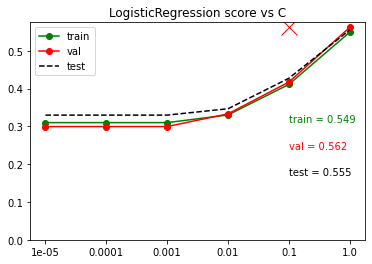

<Figure size 432x288 with 0 Axes>

In [9]:
LogisticRegressionEstimators = train_estimators(X_train, y_train, sklearn.linear_model.LogisticRegression,
                                   'C', [1e-05, 0.0001, 0.001,0.01,0.1,1.0], max_iter=10000, random_state=0)
plot_estimator_scores(LogisticRegressionEstimators,'C',[1e-05, 0.0001, 0.001,0.01,0.1,1.0])

## SVM Classification

Training SVC(C=0.01, gamma=0.0001, max_iter=10000, random_state=0, )...
Training SVC(C=0.1, gamma=0.0001, max_iter=10000, random_state=0, )...
Training SVC(C=1.0, gamma=0.0001, max_iter=10000, random_state=0, )...
Training SVC(C=10.0, gamma=0.0001, max_iter=10000, random_state=0, )...
Training SVC(C=100.0, gamma=0.0001, max_iter=10000, random_state=0, )...
Training SVC(C=1000.0, gamma=0.0001, max_iter=10000, random_state=0, )...


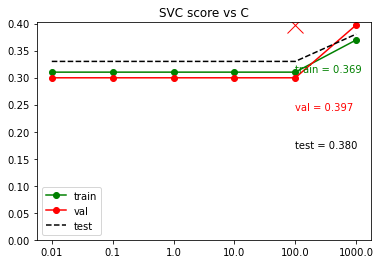

<Figure size 432x288 with 0 Axes>

In [10]:
SVMEstimator = train_estimators(X_train, y_train, sklearn.svm.SVC,
                                   'C', [0.01, 0.1,1.0,10.0,100.0,1000.0],gamma=0.0001,max_iter=10000, random_state=0)
plot_estimator_scores(SVMEstimator,'C',[0.01, 0.1,1.0,10.0,100.0,1000.0])

## Decision Tree Classification

Training DecisionTreeClassifier(max_depth=1, splitter=random, random_state=0, )...
Training DecisionTreeClassifier(max_depth=5, splitter=random, random_state=0, )...
Training DecisionTreeClassifier(max_depth=10, splitter=random, random_state=0, )...
Training DecisionTreeClassifier(max_depth=20, splitter=random, random_state=0, )...
Training DecisionTreeClassifier(max_depth=50, splitter=random, random_state=0, )...
Training DecisionTreeClassifier(max_depth=100, splitter=random, random_state=0, )...


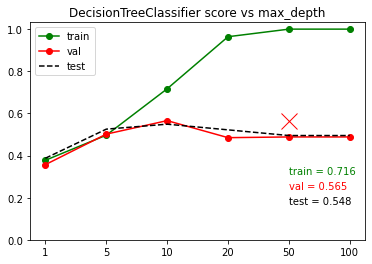

<Figure size 432x288 with 0 Axes>

In [11]:
DecisionTreeEstimators = train_estimators(X_train, y_train, sklearn.tree.DecisionTreeClassifier,
                                   'max_depth', [1, 5, 10,20,50,100], splitter='random', random_state=0)
plot_estimator_scores(DecisionTreeEstimators,'max_depth',[1, 5, 10,20,50,100])

## RandomForest Classification

Training RandomForestClassifier(max_depth=1, random_state=0, )...
Training RandomForestClassifier(max_depth=5, random_state=0, )...
Training RandomForestClassifier(max_depth=10, random_state=0, )...
Training RandomForestClassifier(max_depth=20, random_state=0, )...
Training RandomForestClassifier(max_depth=50, random_state=0, )...
Training RandomForestClassifier(max_depth=100, random_state=0, )...


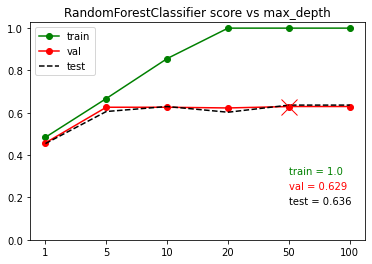

<Figure size 432x288 with 0 Axes>

In [12]:
RandomTreeEstimators = train_estimators(X_train, y_train, sklearn.ensemble.RandomForestClassifier,
                                   'max_depth', [1, 5, 10,20,50,100], random_state=0)
plot_estimator_scores(RandomTreeEstimators,'max_depth',[1, 5, 10,20,50,100])

## K-nearest Classification

Training KNeighborsClassifier(weights=uniform, n_neighbors=2, )...
Training KNeighborsClassifier(weights=distance, n_neighbors=2, )...
Training KNeighborsClassifier(algorithm=auto, n_neighbors=2, )...
Training KNeighborsClassifier(algorithm=ball_tree, n_neighbors=2, )...
Training KNeighborsClassifier(algorithm=kd_tree, n_neighbors=2, )...
Training KNeighborsClassifier(algorithm=brute, n_neighbors=2, )...


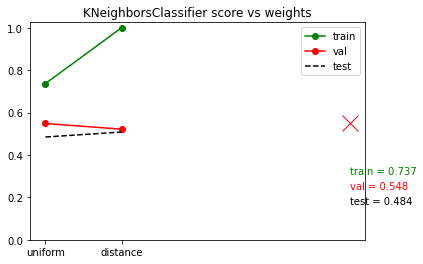

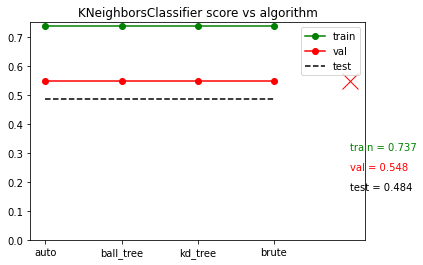

<Figure size 432x288 with 0 Axes>

In [13]:
KNearestEstimators = train_estimators(X_train, y_train, sklearn.neighbors.KNeighborsClassifier,
                                      'weights', ['uniform','distance'],n_neighbors=2)
plot_estimator_scores(KNearestEstimators,'weights', ['uniform','distance'])

KNearestEstimators = train_estimators(X_train, y_train, sklearn.neighbors.KNeighborsClassifier,
                                      'algorithm', ['auto', 'ball_tree', 'kd_tree','brute'],n_neighbors=2)
plot_estimator_scores(KNearestEstimators,'algorithm', ['auto', 'ball_tree', 'kd_tree','brute'])


## Ada Boost Classification

Training AdaBoostClassifier(n_estimators=10, random_state=0, )...
Training AdaBoostClassifier(n_estimators=50, random_state=0, )...
Training AdaBoostClassifier(n_estimators=100, random_state=0, )...
Training AdaBoostClassifier(n_estimators=500, random_state=0, )...
Training AdaBoostClassifier(n_estimators=1000, random_state=0, )...
Training AdaBoostClassifier(n_estimators=5000, random_state=0, )...


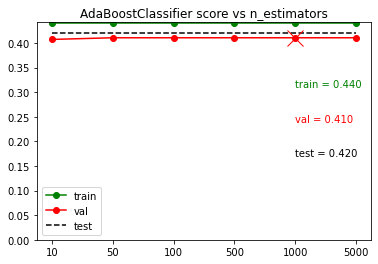

<Figure size 432x288 with 0 Axes>

In [14]:
AdaBoostEstimators = train_estimators(X_train, y_train, sklearn.ensemble.AdaBoostClassifier,
                                   'n_estimators', [10, 50, 100, 500, 1000, 5000], random_state=0)
plot_estimator_scores(AdaBoostEstimators,'n_estimators',[10, 50, 100, 500, 1000, 5000])

## Gaussian Naive Bayes Classification

In [15]:
clf = GaussianNB()
NaiveBayesEstimator=clf.fit(X_train, y_train)
NB_training_scores = NaiveBayesEstimator.score(X_train, y_train)
NB_test_scores =  NaiveBayesEstimator.score(X_test, y_test)
NB_val_scores =  NaiveBayesEstimator.score(X_val, y_val)
print(NB_training_scores,NB_val_scores,NB_test_scores)

0.20337078651685395 0.20875420875420875 0.14814814814814814
